In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import io
import requests
import zipfile

%matplotlib inline

from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

# Multiclass Text Classification 

## 1. Problem Definition
The problem at hand is to develop a multiclass classification model using the Naive Bayes algorithm on processed text data. The goal is to enable machines to understand and gain insights from human language by categorizing text into more than two classes.

## 2. Data
The dataset contains more than two million customer complaints about consumer financial products. Amongst the various available columns, we have a column that contains the actual text of the complaint and one column containing the product for which the customer is raising the complaint
The original data came from the USA data catalog.

https://catalog.data.gov/dataset/consumer-complaint-database


## 3. Evaluation


## Data Exploration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Data_Science/Multiclass-text_classification data/complaints.csv.zip"

Archive:  /content/drive/MyDrive/Data_Science/Multiclass-text_classification data/complaints.csv.zip
  inflating: complaints.csv          


In [4]:
df = pd.read_csv("/content/complaints.csv")
df.head()

<ipython-input-4-3f78f3b87f30>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/complaints.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-01-26,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,20166.0,NaN,Consent not provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5152476
1,2022-03-10,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92394.0,NaN,NaN,Phone,2022-03-10,Closed with explanation,Yes,NaN,5308860
2,2022-03-10,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,DISCOVER BANK,DE,19703.0,NaN,NaN,Referral,2022-03-11,Closed with monetary relief,Yes,NaN,5318105
3,2022-03-10,Checking or savings account,Checking account,Closing an account,Can't close your account,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,TN,38135.0,NaN,NaN,Referral,2022-03-10,Closed with explanation,Yes,NaN,5308021
4,2021-11-12,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,I am XXXX XXXX XXXX and I am submitting this c...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,34236.0,NaN,Consent provided,Web,2021-11-30,Closed with non-monetary relief,Yes,NaN,4906602


In [5]:
# url = "https://files.consumerfinance.gov/ccdb/complaints.json.zip"
# response = requests.get(url)
# zip_file = zipfile.ZipFile(io.BytesIO(response.content))
# file_name = zip_file.namelist()[0]
# data = pd.read_json(zip_file.open(file_name))

# df = pd.DataFrame(data)
# df.head()

In [6]:
df.shape

(3501441, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3501441 entries, 0 to 3501440
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 480.

In [8]:
df['Consumer complaint narrative'][3401]

'I WAS TAKEN ADVANTAGE OF DUE TO MALPRACTICE WHILE SEVERAL LAWS WERE BEING BROKEN BY YOUR COMPANY UNDER THE F.C.R.A, THIS HAS CAUSE ME FINANCIAL INJURY AND THIS IS DEFAMATION OF CHARACHTER. I HAVE BEEN DENIED JOBS BECAUSE OF WHATS ON MY CREDIT REPORT. I HAVE BEEN UNABLE TO LEVERAGE MY ASSETS DURING THE PANDEMIC BECAUSE OF WHATS ON MY CREDIT REPORT. I HAVE BEEN DENIED AN S.B.A. LOAN BECAUSE OF THE NEGATIVE, UNDULY AND ERRONEOUS ITEMS ON MY CREDIT REPORT.'

In [9]:
df['Product'][3401]

'Credit reporting, credit repair services, or other personal consumer reports'

In [10]:
df['Sub-product'][3401]

'Credit reporting'

### Selecting only the important columns for this project

In [11]:
data = df[['Product', 'Sub-product', 'Consumer complaint narrative']]
data.head()

,Product,Sub-product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,NaN
1,"Credit reporting, credit repair services, or o...",Credit reporting,NaN
2,"Credit reporting, credit repair services, or o...",Credit reporting,NaN
3,Checking or savings account,Checking account,NaN
4,"Credit reporting, credit repair services, or o...",Credit reporting,I am XXXX XXXX XXXX and I am submitting this c...


In [12]:
data.isna().sum()

Product                               0
Sub-product                      235291
Consumer complaint narrative    2239143
dtype: int64

### Drop rows with missing `complaint`

In [13]:
data.dropna(inplace=True)

<ipython-input-13-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [14]:
data.isna().sum()

Product                         0
Sub-product                     0
Consumer complaint narrative    0
dtype: int64

In [15]:
data.shape

(1210091, 3)

In [16]:
data.rename({'Consumer complaint narrative': 'Complaint'}, axis =1, inplace=True)
data.head()

<ipython-input-16-dbbb76a0ba69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({'Consumer complaint narrative': 'Complaint'}, axis =1, inplace=True)


,Product,Sub-product,Complaint
4,"Credit reporting, credit repair services, or o...",Credit reporting,I am XXXX XXXX XXXX and I am submitting this c...
7,"Credit reporting, credit repair services, or o...",Credit reporting,in accordance with the Fair Credit Reporting a...
11,"Credit reporting, credit repair services, or o...",Credit reporting,Unauthorized inquiries were discovered on my m...
21,"Credit reporting, credit repair services, or o...",Credit reporting,I am very concerned about the items that are b...
23,Student loan,Federal student loan servicing,I applied to refinance my student loans with C...


In [17]:
data['Sub-product'].value_counts()

Credit reporting                              610145
General-purpose credit card or charge card     69018
Checking account                               63419
Other debt                                     45416
Conventional home mortgage                     42923
                                               ...  
Credit repair                                     39
Traveler’s/Cashier’s checks                       22
Transit card                                      19
Student prepaid card                              17
Electronic Benefit Transfer / EBT card             3
Name: Sub-product, Length: 75, dtype: int64

In [18]:
data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    619494
Debt collection                                                                 202957
Mortgage                                                                        102905
Credit card or prepaid card                                                      91203
Checking or savings account                                                      64316
Student loan                                                                     34494
Money transfer, virtual currency, or money service                               29638
Vehicle loan or lease                                                            22567
Payday loan, title loan, or personal loan                                        14915
Bank account or service                                                          14885
Consumer Loan                                                                     9462
Money transfers                            

### Create Unique Values for `Product`

In [19]:
product_map = {'Vehicle loan or lease': 'vehicle_loan',
              'Credit reporting, credit repair services, or other personal consumer reports':'credit_report',
              'Credit card or prepaid card': 'card',
              'Money transfer, virtual currency, or money service': 'money_transfer',
              'virtual currency': 'money_transfer',
              'Mortgage': 'mortgage',
               'Payday loan, title loan, or personal loan': 'loan',
               'Debt collection': 'debt_collection',
               'Checking or savings account': 'savings_account',
               #'Credit card': 'card',
               'Bank account or service': 'savings_account',
               #'Credit reporting': 'credit_report',
               'Prepaid card': 'card',
               #'Payday loan': 'loan',
               'Other financial service': 'others',
               'Virtual currency': 'money_transfer',
               'Student loan': 'loan',
               'Consumer Loan': 'loan',
               'Money transfers': 'money_transfer'
              }

In [20]:
# Replace the values in the 'product' column using the product_map dictionary
data['Product'] = data['Product'].replace(product_map)

data['Product'].value_counts()

<ipython-input-20-8fe4e23f9c36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Product'] = data['Product'].replace(product_map)


credit_report      619494
debt_collection    202957
mortgage           102905
card                92653
savings_account     79201
loan                58871
money_transfer      31151
vehicle_loan        22567
others                292
Name: Product, dtype: int64

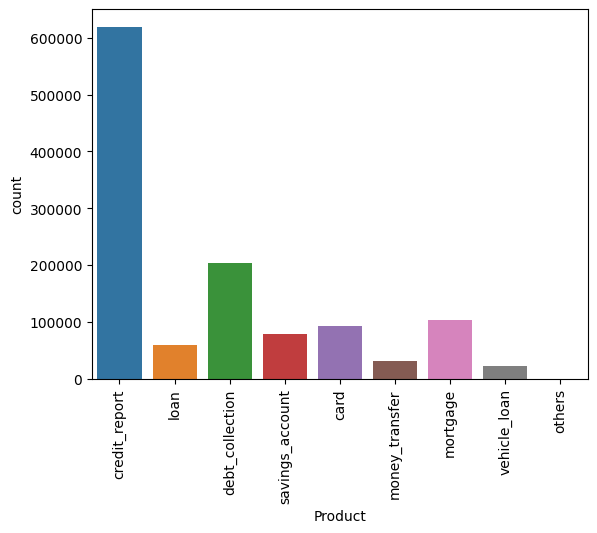

In [21]:
sns.countplot(x="Product", data=data)
plt.xticks(rotation=90)
plt.show()

## Complaints

In [22]:
complaints = list(data['Complaint'])
len(complaints)

1210091

### Convert complaint data to lower case

In [23]:
complaints = [c.lower() for c in tqdm(complaints)]

100%|██████████| 1210091/1210091 [00:01<00:00, 733232.38it/s]


Here, I am using a list comprehension to convert all the elements of the `complaints` list to lowercase letters. The `tqdm` function is used to add a progress bar to the loop, which can be helpful when dealing with large datasets. 

In [24]:
complaints[13]

'i am very concerned about the items that are being shown on my credit report. not only are they inaccurate, they are also unjust, because they should not be reporting on my credit report! i ask that you delete these accounts, or i will be filing a legal complaint against you!'

In [25]:
complaints[3401]

'my credit reports are inaccurate. these inaccuracies are causing creditors to deny me credit. you have the duty to report accurate information about consumers. please investigate these accounts and inquires and update these accounts accordingly to avoid future litigation.'

### Tokenize the text

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
tokens = [word_tokenize(c) for c in tqdm(complaints)]

100%|██████████| 1210091/1210091 [25:40<00:00, 785.63it/s]


Here, the function will take all the `complaints` and break them into tokenize and then give a list of `tokens`

In [30]:
tokens[13]

['i',
 'am',
 'very',
 'concerned',
 'about',
 'the',
 'items',
 'that',
 'are',
 'being',
 'shown',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'not',
 'only',
 'are',
 'they',
 'inaccurate',
 ',',
 'they',
 'are',
 'also',
 'unjust',
 ',',
 'because',
 'they',
 'should',
 'not',
 'be',
 'reporting',
 'on',
 'my',
 'credit',
 'report',
 '!',
 'i',
 'ask',
 'that',
 'you',
 'delete',
 'these',
 'accounts',
 ',',
 'or',
 'i',
 'will',
 'be',
 'filing',
 'a',
 'legal',
 'complaint',
 'against',
 'you',
 '!']

### Remove Stop-words

In [31]:
sw = stopwords.words("english")

In [32]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [33]:
tokens = [[word for word in t if word not in sw]
          for t in tqdm(tokens)]

100%|██████████| 1210091/1210091 [06:00<00:00, 3360.93it/s]


### Remove Punctuation marks

In [34]:
tokenizer = RegexpTokenizer(r'\w+')

In [35]:
tokens = [["".join(tokenizer.tokenize(word)) for word in t
           if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

100%|██████████| 1210091/1210091 [03:38<00:00, 5531.59it/s]


In [36]:
tokens[13]

['concerned',
 'items',
 'shown',
 'credit',
 'report',
 'inaccurate',
 'also',
 'unjust',
 'reporting',
 'credit',
 'report',
 'ask',
 'delete',
 'accounts',
 'filing',
 'legal',
 'complaint']

In [37]:
tokens[0]

['xxxx',
 'xxxx',
 'xxxx',
 'submitting',
 'complaint',
 'third',
 'party',
 'involved',
 'upon',
 'reviewing',
 'updates',
 'incorrect',
 'information',
 'found',
 'still',
 'reports',
 'transunion',
 'xxxx',
 'xxxx',
 'complied',
 'fair',
 'credit',
 'reporting',
 'act',
 '15',
 'usc',
 'sections',
 '1681i',
 'continued',
 'reporting',
 'unverified',
 'information',
 'without',
 'proof',
 'provided',
 'within',
 'time',
 'allowed',
 'law',
 'authorized',
 'inquiries',
 'still',
 'reporting',
 'credit',
 'reports',
 'need',
 'delete',
 'completely',
 'credit',
 'report',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxx',
 'xxxxxxxx',
 'xxxx',
 'xxxxxxxx']

### Remove the `xxxx` and `0000`

In [38]:
tokens = [[t for t in token if t not in ['xxxx','xxxxxxxx', '000']] for token in tqdm(tokens)]

100%|██████████| 1210091/1210091 [00:28<00:00, 41734.18it/s]


In [39]:
tokens[0]

['submitting',
 'complaint',
 'third',
 'party',
 'involved',
 'upon',
 'reviewing',
 'updates',
 'incorrect',
 'information',
 'found',
 'still',
 'reports',
 'transunion',
 'complied',
 'fair',
 'credit',
 'reporting',
 'act',
 '15',
 'usc',
 'sections',
 '1681i',
 'continued',
 'reporting',
 'unverified',
 'information',
 'without',
 'proof',
 'provided',
 'within',
 'time',
 'allowed',
 'law',
 'authorized',
 'inquiries',
 'still',
 'reporting',
 'credit',
 'reports',
 'need',
 'delete',
 'completely',
 'credit',
 'report']

## Data

In [40]:
data["clean_complaints"] = tokens

<ipython-input-40-9ba6f2e602ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clean_complaints"] = tokens


In [41]:
data.head()

,Product,Sub-product,Complaint,clean_complaints
4,credit_report,Credit reporting,I am XXXX XXXX XXXX and I am submitting this c...,"[submitting, complaint, third, party, involved..."
7,credit_report,Credit reporting,in accordance with the Fair Credit Reporting a...,"[accordance, fair, credit, reporting, act, acc..."
11,credit_report,Credit reporting,Unauthorized inquiries were discovered on my m...,"[unauthorized, inquiries, discovered, recent, ..."
21,credit_report,Credit reporting,I am very concerned about the items that are b...,"[concerned, items, shown, credit, report, inac..."
23,loan,Federal student loan servicing,I applied to refinance my student loans with C...,"[applied, refinance, student, loans, citizens,..."


**Let's pick one product type, and check them out**

In [42]:
# Drop the 'Sub-product' column
data = data.drop('Sub-product', axis=1)
data.head()

,Product,Complaint,clean_complaints
4,credit_report,I am XXXX XXXX XXXX and I am submitting this c...,"[submitting, complaint, third, party, involved..."
7,credit_report,in accordance with the Fair Credit Reporting a...,"[accordance, fair, credit, reporting, act, acc..."
11,credit_report,Unauthorized inquiries were discovered on my m...,"[unauthorized, inquiries, discovered, recent, ..."
21,credit_report,I am very concerned about the items that are b...,"[concerned, items, shown, credit, report, inac..."
23,loan,I applied to refinance my student loans with C...,"[applied, refinance, student, loans, citizens,..."


### Loan

In [43]:
loan_complaints = list(data[data["Product"] == "loan"]["clean_complaints"])

In [44]:
loan_complaints = [token for complaint in tqdm(loan_complaints) for token in complaint]

100%|██████████| 58871/58871 [00:00<00:00, 157269.80it/s]


In [45]:
counter = Counter(loan_complaints)
counter.most_common(10)

[('loan', 126090),
 ('payment', 79067),
 ('payments', 64019),
 ('would', 59282),
 ('loans', 58179),
 ('account', 52973),
 ('credit', 48875),
 ('told', 44001),
 ('pay', 40136),
 ('interest', 39265)]

### Card

In [46]:
card_complaints = list(data[data["Product"] == "card"]["clean_complaints"])

In [47]:
# Flatten the list
card_complaints = [token for complaint in tqdm(card_complaints) for token in complaint]

100%|██████████| 92653/92653 [00:00<00:00, 162231.63it/s]


In [48]:
counter = Counter(card_complaints)
counter.most_common(10)

[('card', 216829),
 ('credit', 201068),
 ('account', 162933),
 ('would', 81136),
 ('bank', 80129),
 ('payment', 74800),
 ('told', 64709),
 ('one', 64096),
 ('called', 62398),
 ('received', 61132)]

### Checking for unique tokens in the whole dataset

In [49]:
counter = Counter([t for complaint in tqdm(tokens) for t in complaint])

100%|██████████| 1210091/1210091 [00:04<00:00, 261872.29it/s]


In [50]:
counter.most_common(10)

[('credit', 2120311),
 ('account', 1766995),
 ('report', 1073095),
 ('information', 1055408),
 ('reporting', 788274),
 ('consumer', 654333),
 ('payment', 622153),
 ('would', 599043),
 ('debt', 568983),
 ('loan', 522564)]

In [51]:
print(f"We have {len(counter.keys())} unique tokens in the dataset")

We have 281791 unique tokens in the dataset


In [52]:
clean_complaints = [" ".join(complaint) for complaint in tqdm(tokens)]

100%|██████████| 1210091/1210091 [00:03<00:00, 339595.46it/s]


In [53]:
clean_complaints[13]

'concerned items shown credit report inaccurate also unjust reporting credit report ask delete accounts filing legal complaint'

In [54]:
clean_complaints[0]

'submitting complaint third party involved upon reviewing updates incorrect information found still reports transunion complied fair credit reporting act 15 usc sections 1681i continued reporting unverified information without proof provided within time allowed law authorized inquiries still reporting credit reports need delete completely credit report'

In [55]:
clean_complaints[3401]

'credit reports inaccurate inaccuracies causing creditors deny credit duty report accurate information consumers please investigate accounts inquires update accounts accordingly avoid future litigation'

## Vectorize the Data

In [56]:
vect = CountVectorizer(min_df=200)

**The `min_df=200` parameter sets the minimum document frequency for the CountVectorizer. This means that only terms that appear in at least `200` documents will be included in the vocabulary. Terms that appear in fewer than `200` documents will be ignored.**




In [57]:
X = vect.fit_transform(clean_complaints)

In [58]:
X.shape

(1210091, 9677)

In [59]:
y = data["Product"]

## Model Building

### Train | Test Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (968072, 9677)
X_test: (242019, 9677)
y_train: (968072,)
y_test: (242019,)


**The `stratify=y` parameter ensures that the proportion of classes in the training and test sets is the same as in the original data.**

### Model Training

In [61]:
# MultiNomial Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test data
test_pred = model.predict(X_test)

accuracy_score(y_test, test_pred)

0.7947351241018267

In [62]:
# MultiNomial Naive Bayes
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Predict on the test data
test_pred = logreg_model.predict(X_test)

accuracy_score(y_test, test_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8432478441775233

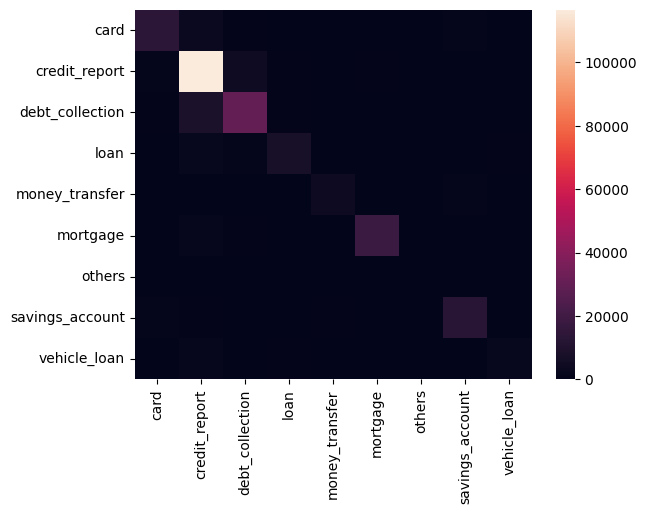

In [65]:
# Correlation Matrix
conf_mat = confusion_matrix(y_test, test_pred)
corr = pd.DataFrame(conf_mat, columns = logreg_model.classes_, index = logreg_model.classes_)

sns.heatmap(corr)
plt.show()

In [67]:
corr

,card,credit_report,debt_collection,loan,money_transfer,mortgage,others,savings_account,vehicle_loan
card,13357,2885,731,110,230,60,0,1133,25
credit_report,1264,116647,4102,538,29,669,2,276,372
debt_collection,522,8502,30044,606,53,449,3,218,195
loan,273,2012,1190,7307,34,272,3,191,492
money_transfer,311,254,131,41,4090,42,1,1356,4
mortgage,100,1557,485,185,25,18019,0,180,30
others,1,8,10,7,9,7,2,14,0
savings_account,1001,898,310,82,663,171,0,12700,15
vehicle_loan,135,1374,315,645,10,65,0,54,1916


### Save the vectorizer and model object

In [68]:
import pickle

with open("count_vect.pkl", "wb") as f:
  pickle.dump(vect, f)

with open("log_model.pkl", "wb") as f:
  pickle.dump(logreg_model, f)

## Prediction

Since I don't have a test dataset would just have to make do with generating something

In [70]:
data["Complaint"][1545]

'In accordance with the Fair Credit Reporting act XXXX XXXX  Account # XXXX, has violated my rights. \n\n15 U.S.C 1681 section 602 A. States I have the right to privacy.\n\n15 U.S.C 1681 Section 604 A Section 2 : It also states a consumer reporting agency can not furnish a account without my written instructions'

In [71]:
data["Product"][1545]

'credit_report'

In [72]:
data["Complaint"][5001]

'Yet again a case of the credit companys not following the rules and listing accounts on my credit profile when the account was remove and then placed back on my file without proof that it is even my account this needs to stop.'

In [73]:
data["Product"][5001]

'credit_report'

In [76]:
data["Complaint"][1200]

'I received a credit card that I have not applied or requested for from Capital One. It came by mail on XX/XX/XXXX. \n\nI called Capital One the following day ( XX/XX/XXXX ) and talked to three different representatives who were all very helpful, and I requested that my account be deleted. The last person I talked to, identified herself as an account manager, assured me that my account has by then been deleted and that there will be an investigation as to how a request for a credit card came to be. She also informed me, after I asked, that the processing of the new card was initiated on XX/XX/XXXX. She gave me a timeline of 60 to 90 days for them to figure out what happened.\n\nHowever what bothered me was that they had all my personal information. As the call progressed, I was asked to verify my identity by giving my name, social security number ( last 4 digits ), my date of birth and of course my address. \n\nI am very sure I did not apply for this card. I don\'t remember If I ever h

In [77]:
data["Product"][1200]

'card'

In [78]:
test_complaint_1 = data["Complaint"][1545]
test_complaint_2 = data["Complaint"][1200]

test_complaint = [test_complaint_1, test_complaint_2]

In [79]:
# Load the vectorizer and model

vect = pickle.load(open("count_vect.pkl", "rb"))
model = pickle.load(open("log_model.pkl", "rb"))

In [80]:
# Process test data
test_complaint = [r.lower() for r in test_complaint]
test_complaint

['in accordance with the fair credit reporting act xxxx xxxx  account # xxxx, has violated my rights. \n\n15 u.s.c 1681 section 602 a. states i have the right to privacy.\n\n15 u.s.c 1681 section 604 a section 2 : it also states a consumer reporting agency can not furnish a account without my written instructions',
 'i received a credit card that i have not applied or requested for from capital one. it came by mail on xx/xx/xxxx. \n\ni called capital one the following day ( xx/xx/xxxx ) and talked to three different representatives who were all very helpful, and i requested that my account be deleted. the last person i talked to, identified herself as an account manager, assured me that my account has by then been deleted and that there will be an investigation as to how a request for a credit card came to be. she also informed me, after i asked, that the processing of the new card was initiated on xx/xx/xxxx. she gave me a timeline of 60 to 90 days for them to figure out what happened

In [82]:
test_tokens = [word_tokenize(r) for r in test_complaint]

In [83]:
test_tokens = [[word for word in t if word not in sw] for t in test_tokens]

test_tokens = [["".join(tokenizer.tokenize(word)) for word in t
                if len(tokenizer.tokenize(word)) > 0] for t in test_tokens]

test_tokens = [[t for t in token if t not in ["xxxx", "xx"]] for token in test_tokens]

In [84]:
clean_test_complaints = [" ".join(complaint) for complaint in test_tokens]

In [85]:
# Vectorize the test data
X_test = vect.transform(clean_test_complaints)

In [86]:
# Make Predictions
model.predict(X_test)

array(['credit_report', 'card'], dtype=object)

**Author:** `Jammal Adeyemi`